# DeepLabCut - Tutorial for BUCTD models

<a target="_blank" href="https://colab.research.google.com/github/DeepLabCut/DeepLabCut/blob/main/examples/COLAB/COLAB_BUCTD_and_CTD_tracking.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**This tutorial introduces the use of [bottom-up conditioned top-down](https://openaccess.thecvf.com/content/ICCV2023/papers/Zhou_Rethinking_Pose_Estimation_in_Crowds_Overcoming_the_Detection_Information_Bottleneck_ICCV_2023_paper.pdf) pose estimation models (also named BUCTD or CTD) in DeepLabCut. This architecture is state-of-the-art in crowded images (when animals are interacting closely with one another), and carry the huge advantage that they can be used to directly track animals, removing the need for tracklet creation or stitching.**

Some resources that can be useful:

- The original paper: [Zhou, Stoffl, Mathis, Mathis. "Rethinking Pose Estimation in Crowds: Overcoming the Detection Information Bottleneck and Ambiguity." Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV). 2023](https://openaccess.thecvf.com/content/ICCV2023/papers/Zhou_Rethinking_Pose_Estimation_in_Crowds_Overcoming_the_Detection_Information_Bottleneck_ICCV_2023_paper.pdf)
- Multi-animal user guide: [DeepLabCut's Documentation: User Guide for Multi-Animal projects](https://deeplabcut.github.io/DeepLabCut/docs/maDLC_UserGuide.html)

Note: In this notebook, we first train a BU model. Typically, you would already have a BU model, that is not performant enough. That's why you go for the BUCTD approach.

## Introduction

This notebook is an introduction to training and using CTD models in DeepLabCut, through the [maDLC Tri-Mouse Benchmark Dataset](https://zenodo.org/records/5851157) presented Lauer et al. 2022 (Nature Methods). For more information, you can check out the [DeepLabCut Benchmark Datasets](https://benchmark.deeplabcut.org/datasets.html).

In this notebook, we'll

- train an bottom-up model that can provide conditions for the CTD model
- evaluate the bottom-up model
- (optional/advanced) learn how the CTD model is trained with generative sampling
- train the CTD model
- evaluate the CTD model
- **(Nice feature of CTD models)** use the CTD model to track individuals

Note: This notebook **can also be run locally**. However, using a GPU is recommended to train the models and run video inference. Just skip the _Installing DeepLabCut on COLAB_ section

### ⚠️⚠️ Change the Runtime type to use a GPU!⚠️⚠️

First, go to "Runtime" ->"change runtime type"->select "Python3", and then select "GPU".

### Installing DeepLabCut on COLAB

Let's install the latest version of DeepLabCut, straight from GitHub.

In [ ]:
# !pip install --pre deeplabcut

**(Be sure to click "RESTART RUNTIME" if it is displayed above before moving on !)** You will see this button at the output of the cells above ^.

### Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import requests
import shutil
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import deeplabcut
import deeplabcut.pose_estimation_pytorch as dlc_torch
import deeplabcut.utils.auxiliaryfunctions as auxiliaryfunctions
import matplotlib.pyplot as plt
import numpy as np

Loading DLC 3.0.0rc13...


/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the Tri-Mouse Dataset

This cell downloads the Tri-Mouse dataset from Zenodo into the current working directory (or `cwd`), which should be the directory you launched the jupyter server from.

In [ ]:
# download_path = Path.cwd()
# download_path = Path('/home/gxj/Desktop/gxj')
# config = str(download_path / "trimice-dlc-2021-06-22" / "config.yaml")

In [ ]:
# print(f"Downloading the tri-mouse dataset into {download_path}")

# url_record = "https://zenodo.org/api/records/5851157"
# response = requests.get(url_record)
# if response.status_code == 200:
#     file = response.json()["files"][0]
#     title = file["key"]
#     print(f"Downloading {title}...")
#     with requests.get(file['links']['self'], stream=True) as r:
#         with ZipFile(BytesIO(r.content)) as zf:
#             zf.extractall(path=download_path)
# else:
#     raise ValueError(f"The URL {url_record} could not be reached.")


# # Check that the config was downloaded correctly
# print(f"Config path: {config}")
# if not Path(config).exists():
#     print(f"Could not find config at {config}: check that the dataset was downloaded correctly!")


Config path: /home/gxj/Desktop/gxj/trimice-dlc-2021-06-22/config.yaml
Config path: /home/gxj/Desktop/gxj/trimice-dlc-2021-06-22/config.yaml


## Training a CTD Model in DeepLabCut

BUCTD (or bottom-up conditioned top-down), as its name suggests, requires a bottom-up model to provide conditions (or **pose proposals**) for the CTD model to fix. So the first step in getting a CTD model that can be used to run inference is to train a bottom-up model to provide conditions!

We'll also **ensure that we're training the bottom-up and CTD models on the same train/test splits!** This is important: if you're training the models on different training images and evaluating them on different test images, then their results aren't comparable!

In [2]:
config = os.path.join("/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19", "config.yaml")
cfg = auxiliaryfunctions.read_config(config)
train_frac = cfg["TrainingFraction"][0]
print(f"Using {int(100 * train_frac)}% of the data in the training set.")

num_images = 345
train_images = int(train_frac * num_images)

seed = 0
rng = np.random.default_rng(seed)

train_indices = rng.choice(num_images, size=train_images, replace=False, shuffle=False).tolist()
test_indices = [idx for idx in range(num_images) if idx not in train_indices]


Using 95% of the data in the training set.


### Training a BU Model

We'll take the simplest approach possible here and train a ResNet pose estimation model. As the CTD model will be used to improve the predictions made by the BU model, we want something light and fast rather than something heavy and slow!

We'll start by **creating the shuffle for the bottom-up model (with index 1) with the selected train/test split**.

In [3]:
BU_SHUFFLE = 1

deeplabcut.create_training_dataset(
    config,
    Shuffles=[BU_SHUFFLE],
    trainIndices=[train_indices],
    testIndices=[test_indices],
    net_type="resnet_50",
    engine=deeplabcut.Engine.PYTORCH,
    userfeedback=False,
)

Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
You passed a split with the following fraction: 95%
Creating training data for: Shuffle: 1 TrainFraction:  0.95


100%|██████████| 327/327 [00:00<00:00, 7335.09it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


We can then train the model defined in the created bottom-up shuffle. To make running this notebook a bit quicker, we'll **only train the BU model for 100 epochs**. The model should still perform well enough, and as we're less interested in the BU model than the CTD model we'll save a bit of time and compute here. Training the model should **take 10 to 20 minutes**, depending on your CPU and GPU performance.


In [4]:
deeplabcut.train_network(
    config,
    shuffle=BU_SHUFFLE,
    epochs=100,
    save_epochs=5
)

Training with configuration:
data:
  bbox_margin: 20
  colormode: RGB
  inference:
    normalize_images: True
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [0.5, 1.25]
      translation: 0
    crop_sampling:
      width: 448
      height: 448
      max_shift: 0.1
      method: hybrid
    gaussian_noise: 12.75
    motion_blur: True
    normalize_images: True
device: auto
inference:
  multithreading:
    enabled: True
    queue_length: 4
    timeout: 30.0
  compile:
    enabled: False
    backend: inductor
  autocast:
    enabled: False
metadata:
  project_path: /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19
  pose_config_path: /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle1/train/pytorch_config.yaml
  bodyparts: ['Snout', 'EarL', 'EarR', 'SpineF', 'SpineM', 'TailB', 'TailM', 'TailE', 'LimbFL', 'LimbFR', 'LimbHL', 'LimbHR']
  unique_bodyparts: []
  individuals: ['SF1', 'WT']
  with_identity: False
method: 

And finally we evaluate it! If you trained for 100 epochs, you should get an mAP around 90, and RMSE around 4-5 pixels. When calling `evaluate_network`, the PAF graph is pruned (as described in [Lauer et al. 2022 (Nature Methods)](https://www.nature.com/articles/s41592-022-01443-0)) to boost performance.

In [5]:
deeplabcut.evaluate_network(config, Shuffles=[BU_SHUFFLE])

Evaluation scorer: DLC_Resnet50_kpms_dlcNov19shuffle1_snapshot_best-100


100%|██████████| 18/18 [00:03<00:00,  5.73it/s]


Evaluation results file: DLC_Resnet50_kpms_dlcNov19shuffle1_snapshot_best-100-results.csv
Evaluation results for DLC_Resnet50_kpms_dlcNov19shuffle1_snapshot_best-100-results.csv (pcutoff: 0.6):
train rmse             4.56
train rmse_pcutoff     4.46
train mAP             95.77
train mAR             96.64
test rmse              7.98
test rmse_pcutoff      7.30
test mAP              87.55
test mAR              88.33
Name: (0.95, 1, 100, -1, 0.6), dtype: float64


### Training the CTD Model

As for the BU model, we need to start by creating the shuffle for the CTD model. We'll use `create_training_dataset_from_existing_split` to create a shuffle with the same train/test split as the BU shuffle. You could equivalently call `create_training_dataset(..., trainIndices=[train_indices], testIndices=[test_indices], ...)` again, as done above for the BU shuffle.

In this notebook, we'll use a preNet CTD architecture. You can check out the paper for more information on how preNet models are designed!

We'll also specify which model we want to use to provide conditions with the `ctd_conditions` parameter. As is indicated in the docstring:

```
ctd_conditions: int | str | Path | tuple[int, str] | tuple[int, int] | None, default = None,
  If using a conditional-top-down (CTD) net_type, this argument should be specified. It defines the
  conditions that will be used with the CTD model. It can be either:
    * A shuffle number (ctd_conditions: int), which must correspond to a bottom-up (BU) network type.
    * A predictions file path (ctd_conditions: string | Path), which must correspond to a
      .json or .h5 predictions file.
    * A shuffle number and a particular snapshot (ctd_conditions: tuple[int, str] | tuple[int, int]),
      which respectively correspond to a bottom-up (BU) network type and a particular snapshot name or
      index.
```

We'll use the index of the BU shuffle defined above, and the best snapshot that was saved (indicated through a -1). You can edit which model is used to provide conditions through the `pytorch_config` for the `CTD_SHUFFLE` (in this case shuffle `2`):

```yaml
# Example: Loading the predictions for snapshot-250.pt of shuffle 1.
inference:
  conditions:
    shuffle: 1
    snapshot: snapshot-250.pt

# Example: Loading the predictions for the last snapshot of shuffle 1.
inference:
  conditions:
    shuffle: 1
    snapshot_index: -1
```

In [6]:
CTD_SHUFFLE = 2

deeplabcut.create_training_dataset_from_existing_split(
    config,
    from_shuffle=BU_SHUFFLE,
    shuffles=[CTD_SHUFFLE],
    net_type="ctd_coam_w32",
    engine=deeplabcut.Engine.PYTORCH,
    ctd_conditions=(BU_SHUFFLE, -1),
    userfeedback=False,
)

Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
You passed a split with the following fraction: 95%
Creating training data for: Shuffle: 2 TrainFraction:  0.95


100%|██████████| 327/327 [00:00<00:00, 18332.63it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


#### (Optional/Advanced) Learning and visualizing generative sampling during training

You can skip this section (and move on to _Training and Evaluating the CTD Model_) as it's simply to visualize how CTD models are trained, if you aren't interested in learning about it.

This section **uses some internal DeepLabCut functions which may seem a bit complicated if you're not used to using them; you can ignore most of the code and just read the text/comments and look at the outputs if you're more comfortable with that.**

Conditional top-down models are trained using _generative sampling_, as introduced in PoseFix \[1\]. For every ground truth pose, we'll add some errors. The errors that can be introduced are:

- Jitter error is defined as a small displacement from the GT keypoint.
- Swap error represents a confusion between the same or similar parts which belong to different persons.
- Inversion error occurs when a pose estimation model is confused between semantically similar parts that belong to the same instance.
- Miss error represents a large displacement from the GT keypoint position.

It's important that "enough" generative sampling is applied (so the model can learn how to correct errors), but applying too much can be bad too! You want the model to learn to correct errors that are realistic (w.r.t. the task at hand), not just receive random points and have to learn by itself where the keypoints go. **The default parameters should work well on most datasets.**

The way these keypoints are "sampled" can be visuallized below. We'll create a `dataset` (which is used by DeepLabCut for training) and sample some data from this dataset. You can see that every time we sample an image, we get different keypoint conditions that will be given to the model. This ensures that the model is well trained to deal with a variety of mistakes that can be made by the bottom up model. On the left side of the plots, you have an image with the ground truth keypoints annotated. On the right side of the plots, you have the pose conditions that the CTD model will receive and will be tasked with fixing.

> \[1\]: Moon, Gyeongsik, Ju Yong Chang, and Kyoung Mu Lee. "Posefix: Model-agnostic general human pose refinement network." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019

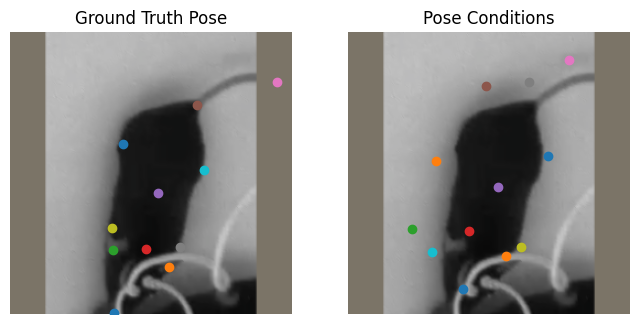

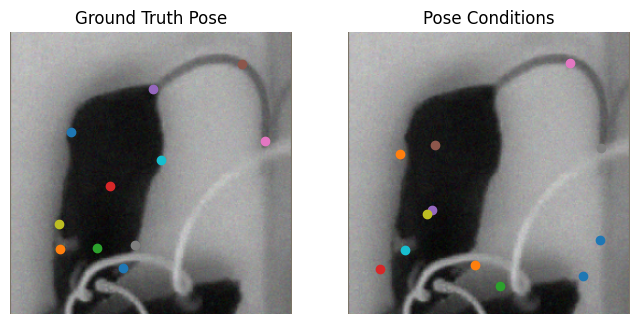

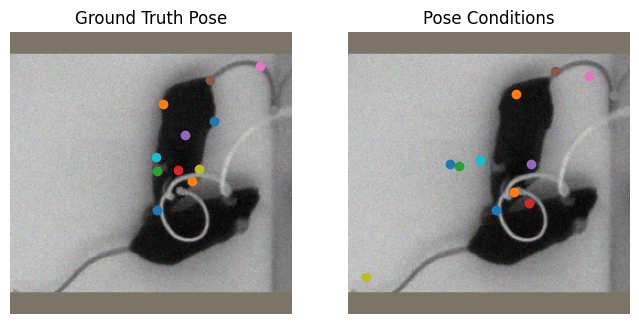

In [7]:
def plot_generative_sampling(dataset: dlc_torch.PoseDataset) -> None:
    # Sample the same image 3 times and plot the results
    for i in range(3):
        item = dataset[0]

        # Remove ImageNet normalization from the image so it displays well
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = item["image"].transpose((1, 2, 0))
        img = np.clip(img * std + mean, 0, 1)

        # Get the ground trouth and "conditional pose"
        gt_pose = item["annotations"]["keypoints"][0]
        gen_samples = item["context"]["cond_keypoints"][0]

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        for ax in axs:
            ax.imshow(img)
            ax.axis("off")

        # plot the ground truth on the left and conditions on the right
        for ax, title, keypoints in zip(
            axs,
            ["Ground Truth Pose", "Pose Conditions"],
            [gt_pose, gen_samples],
        ):
            ax.set_title(title)
            for x, y, vis in keypoints:
                if vis > 0:
                    ax.scatter([x], [y])


ctd_loader = dlc_torch.DLCLoader(config, shuffle=CTD_SHUFFLE)

transform = dlc_torch.build_transforms(ctd_loader.model_cfg["data"]["train"])
dataset = ctd_loader.create_dataset(transform, mode="train", task=ctd_loader.pose_task)

# Fix the seeds for reproducibility; you can change the seed from `0` to another value
# to change the results
dlc_torch.fix_seeds(0)
plot_generative_sampling(dataset)

The generative sampling can be parameterized through the `pytorch_config.yaml` as well. Let's play around with these parameters a bit and see how that changes the conditions that will be given to the model.

First, we'll just lower the `keypoint_sigmas`, which impacts how much pose conditions can move during jittering.

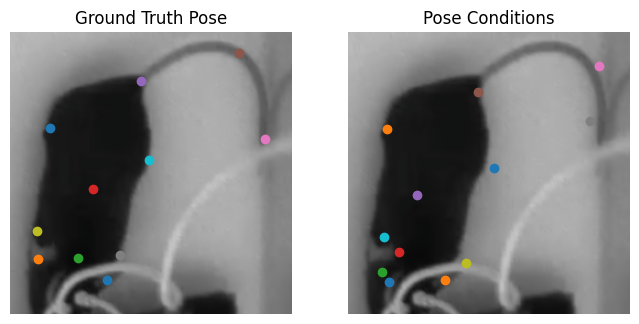

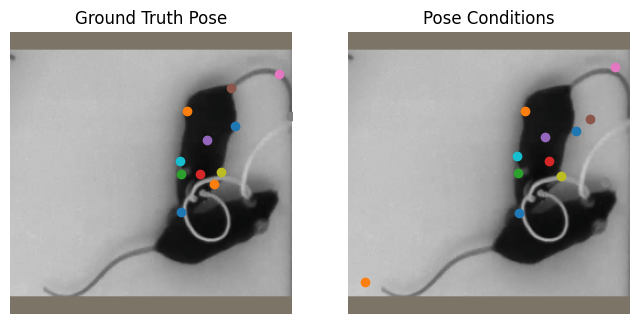

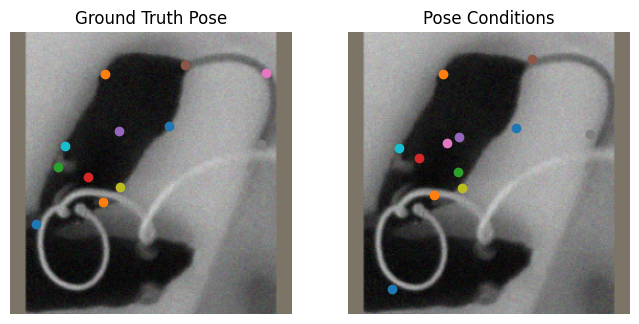

In [8]:
ctd_loader = dlc_torch.DLCLoader(config, shuffle=CTD_SHUFFLE)

# We'll edit the model config here directly; In practice, edit the pytorch_config file instead.
# The parameters that can be set here are the parameters of the `dlc_torch.GenSamplingConfig`
ctd_loader.model_cfg["data"]["gen_sampling"] = {
    # lower the keypoint sigma by a factor of 2 (default: 0.1)
    #   -> this changes by how much keypoints are jittered; the smaller
    #      the value, the smaller the jitter
    "keypoint_sigmas": 0.05,
}

transform = dlc_torch.build_transforms(ctd_loader.model_cfg["data"]["train"])
dataset = ctd_loader.create_dataset(transform, mode="train", task=ctd_loader.pose_task)

# Fix the seeds for reproducibility; you can change the seed from `0` to another value
# to change the results
dlc_torch.fix_seeds(0)
plot_generative_sampling(dataset)

Next, we'll update the probabilities of make errors. You can edit these values yourself to see how it impacts the generative sampling. Note that these probabilities are **not absolute** - as a single type of error is applied to each keypoint, changing the probability of one type of error happening will change the probability that other types of errors occur.

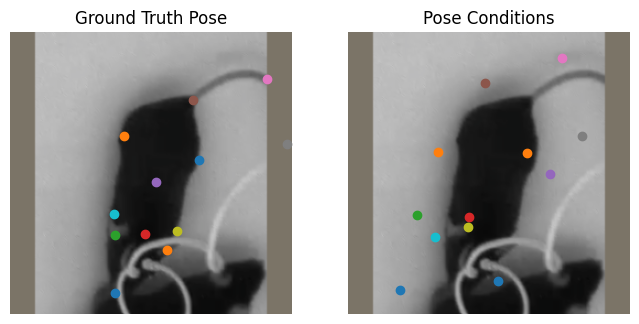

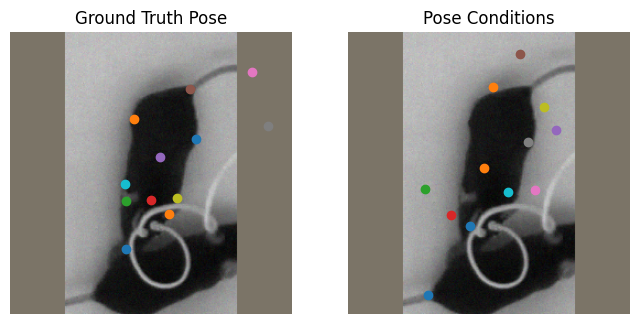

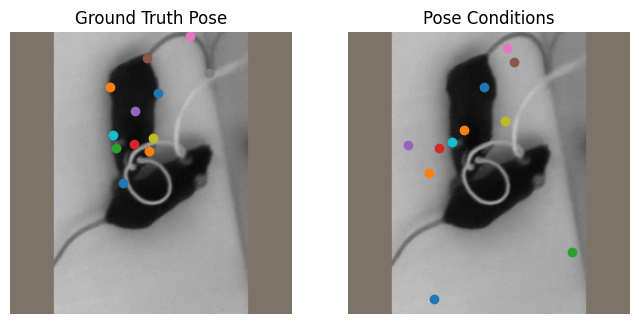

In [9]:
ctd_loader = dlc_torch.DLCLoader(config, shuffle=CTD_SHUFFLE)

# We'll edit the model config here directly; In practice, edit the pytorch_config file instead.
# The parameters that can be set here are the parameters of the `dlc_torch.GenSamplingConfig`
ctd_loader.model_cfg["data"]["gen_sampling"] = {
    "jitter_prob": 0.5,
    "swap_prob": 0.1,
    "inv_prob": 0.1,
    "miss_prob": 0.25,
}

transform = dlc_torch.build_transforms(ctd_loader.model_cfg["data"]["train"])
dataset = ctd_loader.create_dataset(transform, mode="train", task=ctd_loader.pose_task)

# Fix the seeds for reproducibility; you can change the seed from `0` to another value
# to change the results
dlc_torch.fix_seeds(0)
plot_generative_sampling(dataset)

#### Training and Evaluating the CTD Model

Next, we can simply train the CTD model. It should take **20 to 60 minutes** to train the model to 150 epochs on a GPU, depending on the performance of the machine you're on.

If you think your model has converged before the end of training, you can always interrupt the execution of the cell using the "Stop" button, as I did here after 150 epochs. The best-performing model up to that point should be saved.

You'll notice that in the logs for the bottom-up model above, it's printed `using 78 images and 34 for testing` while now it's showing `using 234 images and 102 for testing`. This is because CTD models (and top-down models) perform pose estimation on each mouse indenpendently! As their are 3 mice per image, each ground-truth image creates 3 examples the model can use for training. Checkout the [docs](https://deeplabcut.github.io/DeepLabCut/docs/pytorch/architectures.html#information-on-multi-animal-models) for more information on different approaches to pose estimation!

In [10]:
deeplabcut.train_network(config, shuffle=CTD_SHUFFLE)

Training with configuration:
data:
  bbox_margin: 25
  colormode: RGB
  inference:
    normalize_images: True
    top_down_crop:
      width: 256
      height: 256
      crop_with_context: False
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [1.0, 1.0]
      translation: 0
    gaussian_noise: 12.75
    motion_blur: True
    normalize_images: True
    top_down_crop:
      width: 256
      height: 256
      crop_with_context: False
  gen_sampling:
    keypoint_sigmas: 0.1
device: auto
inference:
  multithreading:
    enabled: True
    queue_length: 4
    timeout: 30.0
  compile:
    enabled: False
    backend: inductor
  autocast:
    enabled: False
  conditions:
    shuffle: 1
    snapshot_index: -1
metadata:
  project_path: /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19
  pose_config_path: /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/pytorch_config.yaml
  bodyparts: ['Snout', 'EarL', 'EarR', 'Spi

If your CTD model is well trained, it should now outperform the performance of the BU model who's predictions it uses as conditions!

Note that during training, the model is evaluated using pose conditions that were created with generative sampling. When you evaluate the network with the `evaluate_network` method, the performance will be different as you're using the actual conditions from the bottom-up model we trained first.

In [11]:
deeplabcut.evaluate_network(config, Shuffles=[CTD_SHUFFLE])

Evaluation scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180


100%|██████████| 18/18 [00:03<00:00,  5.17it/s]


Evaluation results file: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180-results.csv
Evaluation results for DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180-results.csv (pcutoff: 0.6):
train rmse             6.05
train rmse_pcutoff     5.50
train mAP             95.86
train mAR             96.69
test rmse             11.45
test rmse_pcutoff      9.62
test mAP              90.28
test mAR              91.11
Name: (0.95, 2, 180, -1, 0.6), dtype: float64


## Tracking with CTD

One of the big advantages of having a CTD model is that it can be used to track individuals directly! Let's say you have the pose for your animals at `frame T`. Then you can use those poses as conditions for `frame T+1`, and let your CTD model simply "update" the poses depending on how much your mice moved.

In the simplest scenario, you only need to run the BU model on the first frame, and then the CTD model takes over for inference and tracking:

1. Run the BU model to generate conditions for the 1st frame of the video
2. For every frame after that, use the predictions from the previous frame as conditions

However, this may not fit your scenario perfectly. Maybe all the mice aren't present in the first frame, and if they aren't detected by the BU model they'll never be tracked. Maybe at some point the CTD model makes an error and you lose track of a mouse. There are some options to deal with this:

- Run the BU model every time at least one mouse is not detected (if you expect N mice to be in the video and you only detect N-1 mice, run the BU model):
  - In this case, the predictions from the BU model need to be "merged in" to the existing N-1 tracks
  - We can merge them in by using a similarity score between poses (OKS) which ranges from 0 to 1
  - You likely don't want to run the BU model every frame, as this would slow down inference.
- Run the BU model every K frames in case new mice appear


### Downloading a Tri-Mouse video

First, let's download a video from the Tri-Mouse dataset. Note that this may take some time to run (1 minute or 2). If you have any issues downloading the files through the code, you can simply download the zipfile through [zenodo.org/records/7883589/files/demo-me-2021-07-14.zip](https://zenodo.org/records/7883589/files/demo-me-2021-07-14.zip?download=1), and then drag-and-drop the video in `demo-me-2021-07-14/videos/videocompressed1.mp4` file into COLAB in the right panel to upload it. Make sure the video is fully uploaded before you run analysis.

In [ ]:
# download_path = Path.cwd()
# video_name = "videocompressed1.mp4"
# video_path = str(download_path / video_name)
# print(f"Video will be saved in {video_path}")

Video will be saved in /content/videocompressed1.mp4


In [ ]:
# print(f"Downloading the tri-mouse video into {download_path}")

# url_video_record = "https://zenodo.org/api/records/7883589"
# response = requests.get(url_video_record)
# if response.status_code == 200:
#     file = response.json()["files"][0]
#     title = file["key"]
#     print(f"Downloading {title}...")
#     with requests.get(file['links']['self'], stream=True) as r:
#         with ZipFile(BytesIO(r.content)) as zf:
#             zf.extractall(path=download_path)
# else:
#     raise ValueError(f"The URL {url_video_record} could not be reached.")

# # Check that the video was downloaded
# src_video_path = download_path / "demo-me-2021-07-14" / "videos" / video_name
# if not src_video_path.exists():
#     raise ValueError("Failed to download the video")

# # Move the video to the final path
# shutil.move(src_video_path, video_path)
# if not Path(video_path).exists():
#     raise ValueError("Failed to move the video")


### Running Video Analysis

You can track using your CTD model by setting `ctd_tracking=True` when calling `analyze_videos`. Of course, you then won't need to convert detections to tracklets or link tracklets, as the CTD model will directly be tracking the animals. This should run at 15 to 40 FPS depending on your hardware.

You can create a labeled video containing the predictions made with the CTD tracker by setting `track_method="ctd"` when calling `create_labeled_video`.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import deeplabcut
config = os.path.join("/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19", "config.yaml")
video_paths = [
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi',
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829112115150.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251017131000269.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251017131413476.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103121540923.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103122021978.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103133402648.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103134014586.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104104807552.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104105407508.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106121745074.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106122212288.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106135123189.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106135549021.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251107104640644.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251107105140893.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117121735350.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117122147574.avi', 
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117133600672.avi', 
    # '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117134026528.avi', 
]
CTD_SHUFFLE = 2
for video_path in video_paths:
    deeplabcut.analyze_videos(
        config,
        [video_path],
        shuffle=CTD_SHUFFLE,
        # ctd_tracking=dict(
        #     bu_on_lost_idv=True,
        #     bu_max_frequency=500,
        #     threshold_bu_add=0.8,
        #     threshold_ctd=0.01,
        #     threshold_nms=0.8,
        # ),
        ctd_tracking=True, 
        save_as_csv=True,
    )
    # deeplabcut.create_labeled_video(
    #     config,
    #     [video_path],
    #     shuffle=CTD_SHUFFLE,
    #     track_method="ctd",
    #     color_by="individual",
    #     draw_skeleton=True,
    #     overwrite=True,
    #     plot_bboxes=True,
    #     pcutoff=0.0,
    #     confidence_to_alpha=False,
    # )

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Video /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi already analyzed at /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_full.pickle!
No .h5 files were created during video analysis. Please check your code and ensure that the video inference and output generation are correct.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Video /home/gxj/Desktop/g

 20%|█▉        | 3347/16868 [07:04<31:02,  7.26it/s]/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/pose_estimation_pytorch/data/preprocessor.py:373: RuntimeWarning: All-NaN slice encountered
  aggregate_func: Callable[[np.ndarray], float] = lambda arr: np.nanmax(arr, axis=1),
 20%|█▉        | 3348/16868 [07:04<30:20,  7.43it/s]/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/pose_estimation_pytorch/data/preprocessor.py:373: RuntimeWarning: All-NaN slice encountered
  aggregate_func: Callable[[np.ndarray], float] = lambda arr: np.nanmax(arr, axis=1),
 20%|█▉        | 3349/16868 [07:04<29:46,  7.57it/s]/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/pose_estimation_pytorch/data/preprocessor.py:373: RuntimeWarning: All-NaN slice encountered
  aggregate_func: Callable[[np.ndarray], float] = lambda arr: np.nanmax(arr, axis=1),
 20%|█▉        | 3350/16868 [07:05<29:21,  7.67it/s]/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-pa

Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251017131413476DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251017131413476DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110312154092

100%|██████████| 5328/5328 [11:27<00:00,  7.75it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103121540923DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103121540923DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110312202197

100%|██████████| 16692/16692 [37:46<00:00,  7.37it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103122021978DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103122021978DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110313340264

100%|██████████| 7130/7130 [14:24<00:00,  8.25it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103133402648DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103133402648DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110313401458

100%|██████████| 17636/17636 [34:20<00:00,  8.56it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103134014586DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103134014586DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110410480755

100%|██████████| 5535/5535 [11:50<00:00,  7.79it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104104807552DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104104807552DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110410540750

100%|██████████| 16304/16304 [38:13<00:00,  7.11it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104105407508DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251104105407508DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110612174507

100%|██████████| 4821/4821 [10:15<00:00,  7.83it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106121745074DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251106121745074DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025110710464064

100%|██████████| 5667/5667 [11:08<00:00,  8.48it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251107104640644DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251107104640644DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025111712173535

100%|██████████| 4804/4804 [08:31<00:00,  9.39it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117121735350DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117121735350DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-3/kpms_dlcNov19-trainset95shuffle2/train/snapshot-best-180.pt
CTD tracking can only be used with batch size 1. Updating it.
Using scorer: DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_2025111713360067

100%|██████████| 5071/5071 [08:48<00:00,  9.59it/s]


Saving results in /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117133600672DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd.h5 and /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251117133600672DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.



In [ ]:
video_paths = [
    '/home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20251103133402648.avi',
]
for video_path in video_paths:
    deeplabcut.analyze_videos(
        config,
        [video_path],
        shuffle=BU_SHUFFLE,
    )
    deeplabcut.create_labeled_video(
        config,
        [video_path],
        shuffle=BU_SHUFFLE,
        color_by="individual",
        draw_skeleton=True,
        overwrite=True,
    )

Analyzing videos with /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/dlc-models-pytorch/iteration-0/kpms_dlcNov19-trainset95shuffle1/train/snapshot-best-100.pt
Using scorer: DLC_Resnet50_kpms_dlcNov19shuffle1_snapshot_best-100
Starting to analyze /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi
Video metadata: 
  Overall # of frames:    5596
  Duration of video [s]:  279.80
  fps:                    20.0
  resolution:             w=2448, h=2048

Running pose prediction with batch size 8


  0%|          | 16/5596 [00:03<21:59,  4.23it/s]/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/pose_estimation_pytorch/data/postprocessor.py:514: RuntimeWarning: invalid value encountered in cast
  heatmap_indices = np.rint(individual_keypoints).astype(int)
100%|██████████| 5596/5596 [21:58<00:00,  4.25it/s]


Processing...  /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi
Loading From /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131DLC_Resnet50_kpms_dlcNov19shuffle1_snapshot_best-100.h5


100%|██████████| 5596/5596 [00:10<00:00, 509.94it/s] 


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi


100%|██████████| 30/30 [00:00<00:00, 907.28it/s]
/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/refine_training_dataset/stitch.py:941: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(output_name, "tracks", format="table", mode="w")


The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

Starting to process video: /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi
Loading /home/gxj/Desktop/gxj/kpms_dlc-GXJ-2025-11-19/videos/Video_20250829111623131.avi and data.
Duration of video [s]: 279.8, recorded with 20.0 fps!
Overall # of frames: 5596 with cropped frame dimensions: 2448 2048
Generating frames and creating video.


/home/gxj/.conda/envs/DLC3.0/lib/python3.12/site-packages/deeplabcut/utils/make_labeled_video.py:146: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Dataframe.groupby(level="individuals", axis=1).size().values // 3
100%|██████████| 5596/5596 [04:02<00:00, 23.12it/s]


[True]

We can then visualize the results of tracking with CTD.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, width=640):
    video_file = open(video_path, "rb").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""
    <video width="{width}" controls>
        <source src="{video_url}" type="video/mp4">
    </video>
    """)

output_path = video_path.split('.')[0] + "DLC_CtdCoamW32_kpms_dlcNov19shuffle2_snapshot_best-180_ctd_id_p60_labeled.mp4"
show_video(output_path)

It can be beneficial to customize the tracking parameters a bit. The tracking parameters you can set are:

Note: [OKS (object-keypoint similarity)](https://cocodataset.org/#keypoints-eval) is a similarity metric for pose estimation, ranging from 0 to 1 (where 1 means the pose is identical)

- **`bu_on_lost_idv`**: When True, the BU model is run when there are fewer conditions found than the expected number of individuals in the video.
- **`bu_min_frequency`**: The minimum frequency at which the BU model is run to generate conditions. If None, the BU model is only run to initialize the pose in the first frame, and then is not run again. If a positive number N, the BU model is run every N frames. The BU predictions are then combined with the CTD predictions to continue the tracklets.
- **`bu_max_frequency`**: The maximum frequency at which the BU model can be run. Must be greater than `bu_min_frequency`. When there are fewer conditions than individuals expected in the video and `bu_on_lost_idv` is True, the BU model may be run on every frame. This can happen if individuals can disappear from the video, and each frame may have a variable number of individuals. If `bu_max_frequency` is set to N, then the BU model will be run at most every N-th frame, which improves the inference speed of the model.
- **`threshold_bu_add`**: The OKS threshold below which a BU pose must be (wrt. any existing CTD pose) to be added to the poses.
- **`threshold_ctd`**: The score threshold below which detected keypoints are NOT given to the CTD model to predict pose for the next frame.
- **`threshold_nms`**: The OKS threshold to use for non-maximum suppression. This is used to remove duplicates poses when two CTD model predictions converge to a single animal. If two poses have an OKS above this threshold, one of the poses is removed.


In [ ]:
dest_folder = str(Path(video_path).parent / "custom-ctd-tracking")

deeplabcut.analyze_videos(
    config,
    [video_path],
    shuffle=CTD_SHUFFLE,
    destfolder=dest_folder,
    ctd_tracking=dict(
        bu_on_lost_idv=True,
        bu_max_frequency=10,
        threshold_bu_add=0.5,
        threshold_ctd=0.01,
        threshold_nms=0.8,
    ),
)
deeplabcut.create_labeled_video(
    config,
    [video_path],
    shuffle=CTD_SHUFFLE,
    destfolder=dest_folder,
    track_method="ctd",
    color_by="individual",
)